In [60]:
# параметры робота
# улавливает расстояния от 0 до 9.5 метров 
# # адекватнее: от 0.5 = это расстояние от центра до края (кстати, когда расстояние РАВНО 0.5, это плохо, потому что мы врезались)
# угол обзора лидара 360 градусов

In [61]:
# входы
# угол м-у осью робота и препятствием (alpha) (градусы)
# расстояние между центром робота и препятствием (s) (м)
# скорость робота (линейная) (v) (м/c)

# в первую очередь судить по alpha
# если s <= 0.5, то мы УЖЕ врезались

In [62]:
from fuzzylogic.classes import Domain
from fuzzylogic.functions import gauss, bounded_sigmoid, S, trapezoid, R, triangular

# domains
alpha = Domain("Angle between the robot and an obstacle (degree)", 0, 360)
s = Domain("Distance between the robot and an obstacle (cm)", 50, 950)
v = Domain("Current linear speed of the robot (cm/s)", 0, 1000)

# sets = сделать категории и присвоить им функции принадлежности (NB: моё понимание может быть некорректным)

# alpha
# [0; 30] высокий риск врезаться (препятствие справа)
# [30; 90] средний риск врезаться
# [90; 315] маленький шанс врезаться
# [315; 360] высокий риск врезаться (препятствие слева)

alpha.high_risk_left = bounded_sigmoid(30, 45, inverse=True)
# чтобы максимум доходил до 1
alpha.high_risk_left = alpha.high_risk_left.normalized()
alpha.medium_risk = gauss(70, 0.005, c_m=1)
alpha.high_risk_right = bounded_sigmoid(280, 310, inverse=False)
alpha.high_risk_right = alpha.high_risk_right.normalized()
alpha.low_risk_left = bounded_sigmoid(110, 130, inverse=False)
alpha.low_risk_right = bounded_sigmoid(220, 260, inverse=True)
alpha.low_risk = alpha.low_risk_left & alpha.low_risk_right

# s (в м)
# [0.5; 0.75] остановиться и всё, так как даже для поворота места нет
# [0.75; 1.5] можно повернуть, если позволит скорость
# [1.5; 3.5] можно повернуть, если позволит скорость
# [3.5; 5.5] можно повернуть, если позволит скорость
# [5.5; 7.5] можно повернуть, если позволит скорость
# [7.5; 9.5] можно повернуть, если позволит скорость

# s (в см)
# [50; 75] остановиться и всё, так как даже для поворота места нет (dangerously_close)
# [75; 150] можно повернуть, если позволит скорость (close)
# [150; 350] можно повернуть, если позволит скорость (average_1)
# [350; 550] можно повернуть, если позволит скорость (average_2)
# [550; 750] можно повернуть, если позволит скорость (average_3)
# [750; 950] можно повернуть, если позволит скорость (average_4)
s.dangerously_close = bounded_sigmoid(50, 90, inverse=True)
s.dangerously_close = s.dangerously_close.normalized()
s.close = gauss(125, 0.005, c_m=1)
s.average_1 = gauss(190, 0.005, c_m=1)
s.average_2 = gauss(350, 0.0001, c_m=1)
s.average_3 = gauss(550, 0.0001, c_m=1)
s.average_4 = bounded_sigmoid(800, 850, inverse=False)
s.average_4 = s.average_4.normalized()

# v (см/с)
# в связи с тем, что возможность поворота определяется тем, не превышает ли скорость правую границу текущего диапазона s, функции принадлежности
# для v выглядят похожими
v.very_slow = bounded_sigmoid(50, 90, inverse=True)
v.very_slow = v.very_slow.normalized()
v.slow = gauss(125, 0.005, c_m=1)
v.moderate = gauss(190, 0.005, c_m=1)
v.high = gauss(350, 0.0001, c_m=1)
v.fast = gauss(550, 0.0001, c_m=1)
v.very_fast = bounded_sigmoid(800, 850, inverse=False)
v.very_fast = v.very_fast.normalized()

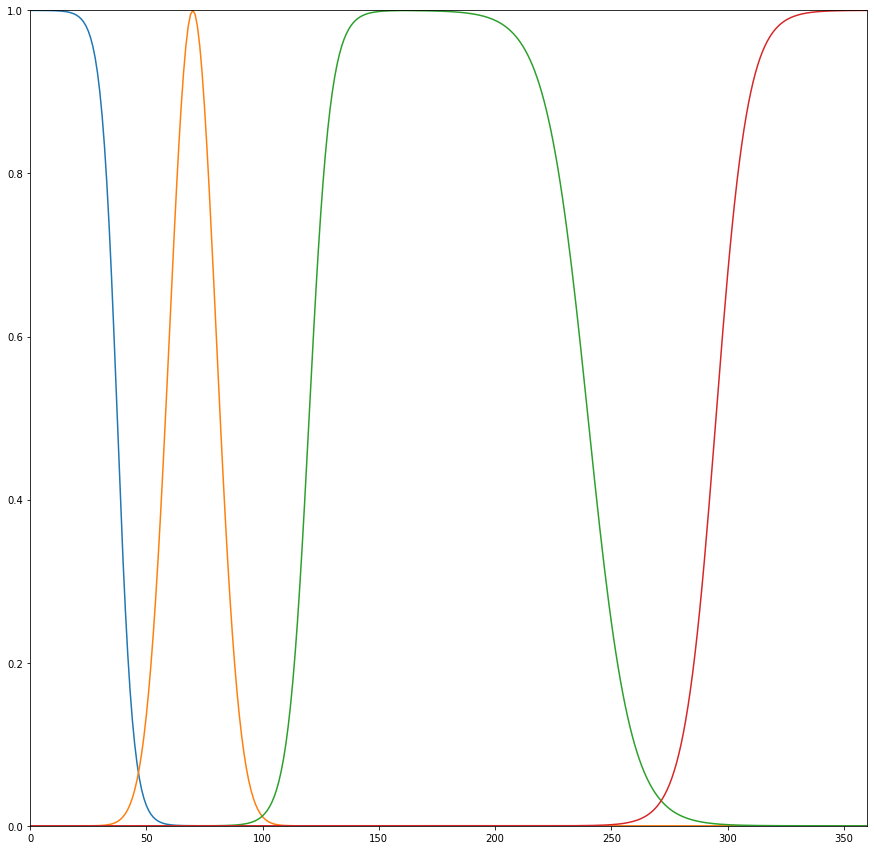

In [63]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

alpha.high_risk_left.plot()
alpha.medium_risk.plot()
alpha.low_risk.plot()
alpha.high_risk_right.plot()

ax.set_xlim(xmin=0, xmax=360)
ax.set_ylim(ymin=0, ymax=1)

fig.set_figwidth(15)
fig.set_figheight(15)

plt.show()
plt.close()

In [64]:
import numpy as np
# start = 0
# step = 0.5
# num = 20
# x_axis_for_s = start + np.arange(0, num) * step
# x_axis_for_s
x_axis_for_s = np.arange(1000, step=50)
x_axis_for_s

array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600,
       650, 700, 750, 800, 850, 900, 950])

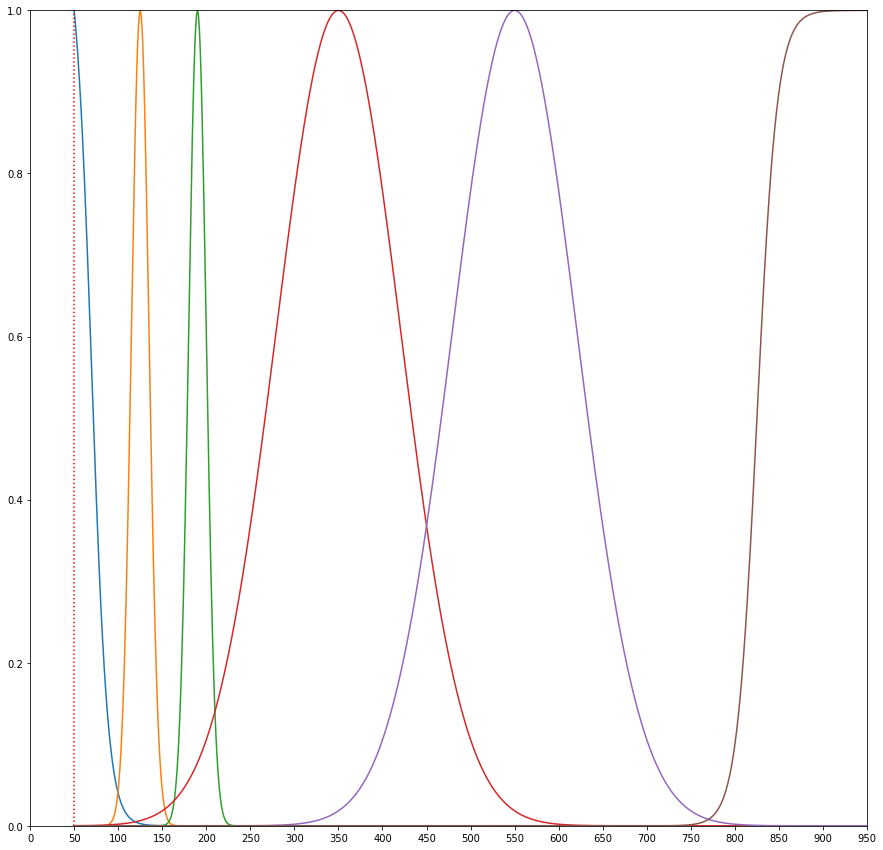

In [65]:
fig, ax = plt.subplots()

s.dangerously_close.plot()
s.close.plot()
s.average_1.plot()
s.average_2.plot()
s.average_3.plot()
s.average_4.plot()

# чтобы было видно, где 0.5
plt.axvline(x=50, linestyle=':', color='r')

# ax.set_xticks(x_axis_for_s)
ax.set_xlim(xmin=0, xmax=950)
ax.set_ylim(ymin=0, ymax=1)

fig.set_figwidth(15)
fig.set_figheight(15)

plt.xticks(x_axis_for_s)
plt.show()
plt.close()

In [68]:
x_axis_for_v = np.arange(1005, step=50)
x_axis_for_v

array([   0,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
        550,  600,  650,  700,  750,  800,  850,  900,  950, 1000])

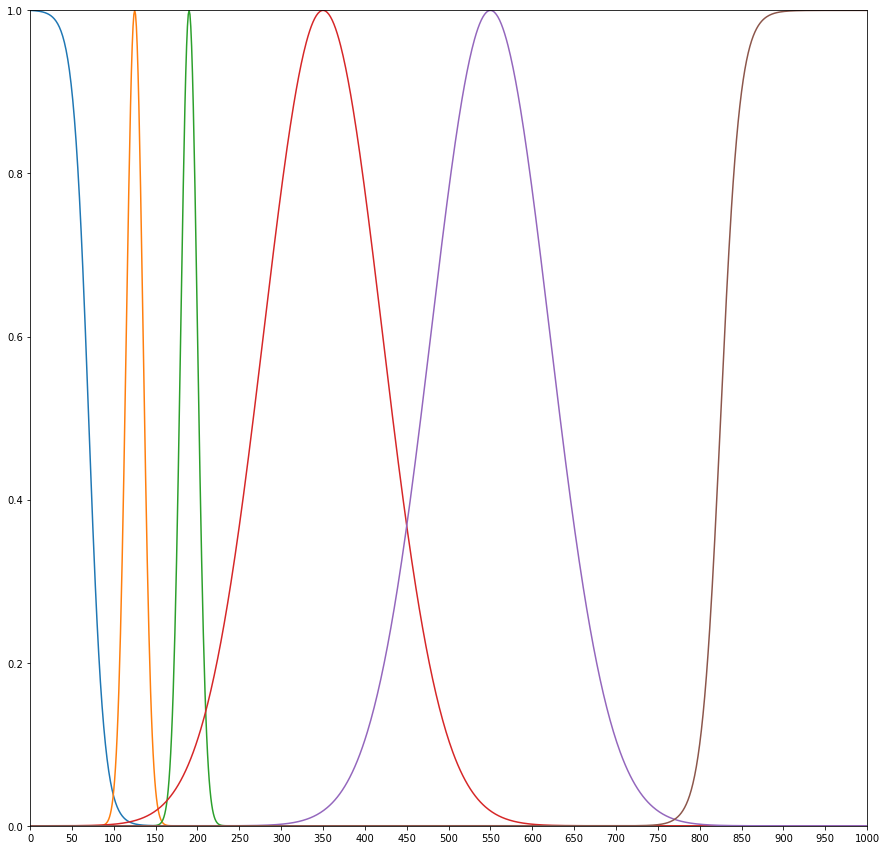

In [69]:
fig, ax = plt.subplots()

v.very_slow.plot()
v.slow.plot()
v.moderate.plot()
v.high.plot()
v.fast.plot()
v.very_fast.plot()

ax.set_xlim(xmin=0, xmax=950)
ax.set_ylim(ymin=0, ymax=1)

fig.set_figwidth(15)
fig.set_figheight(15)

plt.xticks(x_axis_for_v)
plt.show()
plt.close()

In [29]:
# выходы
# целевой угол (куда повернётся робот) (gamma) (градусы)
# # насколько я понимаю, целевой угол -- это не "НА СКОЛЬКО градусов надо повернуть колесо относительно текущего положения", а "какое должно быть новое положение колеса с
# # точки зрения угла"
# # # в таком случае нужно как-то прикинуть оценку, сколько времени поворот будет занимать (успеем ли)
# # # или забить?
# скорость робота (линейная) (v) (м/c)

In [99]:
# gamma
# категории: повернуться вправо ~на 45, повернуться влево ~на 45, повернуться влево ~на большой угол, повернуться вправо на ~большой угол
gamma = Domain("Angle turn", -180, 180)
gamma.low_turn_to_right = gauss(45, 0.001, c_m=1)
gamma.low_turn_to_left = gauss(-45, 0.001, c_m=1)
gamma.high_turn_to_left = bounded_sigmoid(100, 160, inverse=False)
gamma.high_turn_to_left = gamma.high_turn_to_left.normalized()
gamma.high_turn_to_right = bounded_sigmoid(-160, -100, inverse=True)
gamma.high_turn_to_right = gamma.high_turn_to_right.normalized()

# new_v
# категории: медленно, средне, быстро
new_v = Domain("New speed (cm/s)", 0, 1000)
new_v.very_slow = bounded_sigmoid(50, 90, inverse=True)
new_v.very_slow = new_v.very_slow.normalized()
new_v.slow = gauss(125, 0.005, c_m=1)
new_v.moderate = gauss(190, 0.005, c_m=1)
new_v.high = gauss(350, 0.0001, c_m=1)
new_v.fast = gauss(550, 0.0001, c_m=1)
new_v.very_fast = bounded_sigmoid(800, 850, inverse=False)
new_v.very_fast = v.very_fast.normalized()

In [100]:
x_axis_for_gamma = np.arange(start=-180, stop=190, step=10)
x_axis_for_gamma

array([-180, -170, -160, -150, -140, -130, -120, -110, -100,  -90,  -80,
        -70,  -60,  -50,  -40,  -30,  -20,  -10,    0,   10,   20,   30,
         40,   50,   60,   70,   80,   90,  100,  110,  120,  130,  140,
        150,  160,  170,  180])

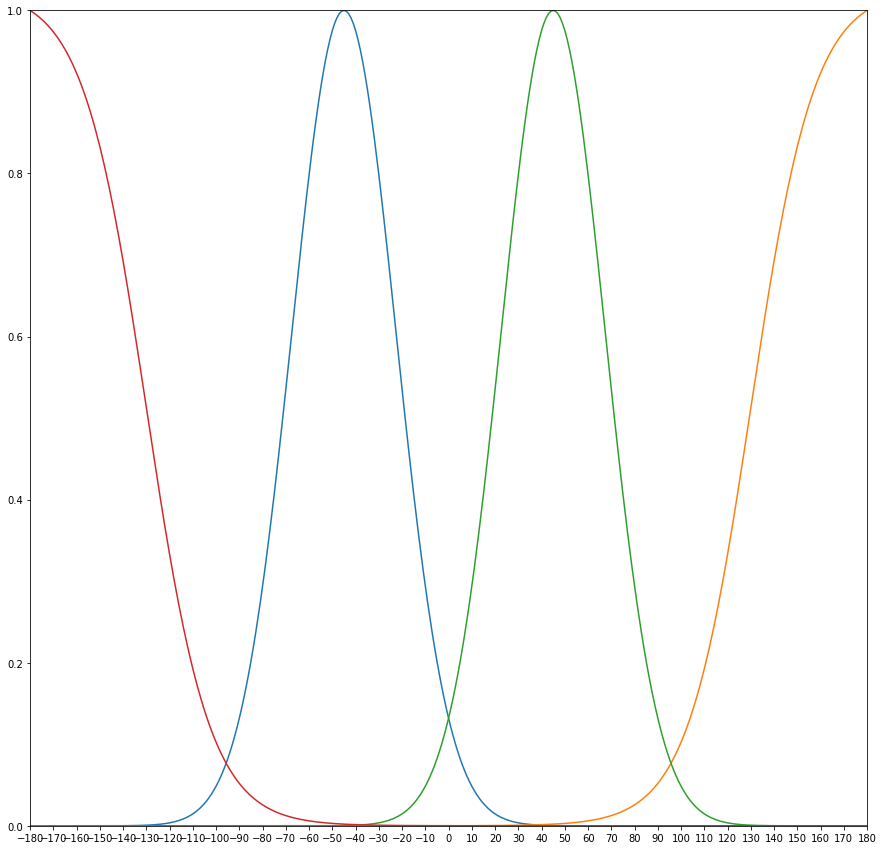

In [109]:
fig, ax = plt.subplots()

gamma.low_turn_to_left.plot() # синий
gamma.high_turn_to_left.plot() # оранжевый
gamma.low_turn_to_right.plot() # зелёный
gamma.high_turn_to_right.plot() # красный

ax.set_xlim(xmin=-180, xmax=180)
ax.set_ylim(ymin=0, ymax=1)

fig.set_figwidth(15)
fig.set_figheight(15)

plt.xticks(x_axis_for_gamma)
plt.show()
plt.close()

In [102]:
x_axis_for_new_v = np.arange(1005, step=50)
x_axis_for_new_v

array([   0,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
        550,  600,  650,  700,  750,  800,  850,  900,  950, 1000])

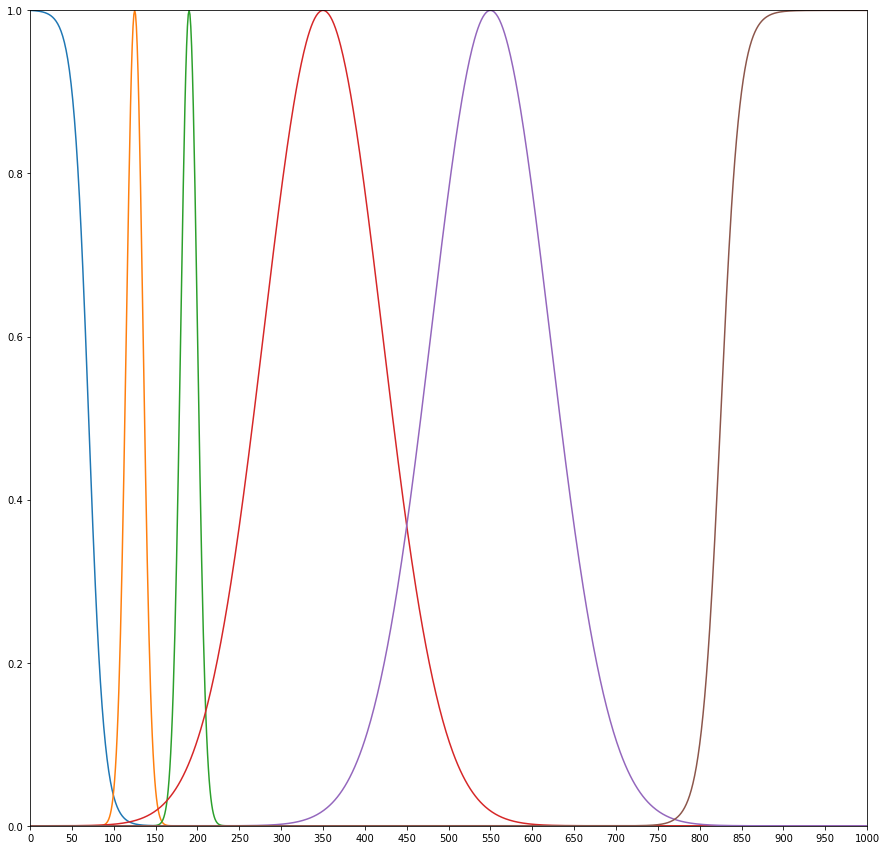

In [103]:
fig, ax = plt.subplots()

new_v.very_slow.plot()
new_v.slow.plot()
new_v.moderate.plot()
new_v.high.plot()
new_v.fast.plot()
new_v.very_fast.plot()

ax.set_xlim(xmin=0, xmax=950)
ax.set_ylim(ymin=0, ymax=1)

fig.set_figwidth(15)
fig.set_figheight(15)

plt.xticks(x_axis_for_new_v)
plt.show()
plt.close()

In [121]:
from fuzzylogic.classes import Rule

# R = Rule({(alpha., s., v.): (gamma., new_v.)})
# только остановиться, пространства для поворота нет
v_R1 = Rule({(alpha.high_risk_left, s.dangerously_close, v.very_slow): new_v.very_slow})
v_R2 = Rule({(alpha.high_risk_left, s.dangerously_close, v.slow): new_v.very_slow})
v_R3 = Rule({(alpha.high_risk_left, s.dangerously_close, v.moderate): new_v.very_slow})
v_R4 = Rule({(alpha.high_risk_left, s.dangerously_close, v.high): new_v.very_slow})
v_R5 = Rule({(alpha.high_risk_left, s.dangerously_close, v.fast): new_v.very_slow})
v_R6 = Rule({(alpha.high_risk_left, s.dangerously_close, v.very_fast): new_v.very_slow})

g_R1 = Rule({(alpha.high_risk_left, s.dangerously_close, v.very_slow): gamma.low_turn_to_right})
g_R2 = Rule({(alpha.high_risk_left, s.dangerously_close, v.slow): gamma.low_turn_to_right})
g_R3 = Rule({(alpha.high_risk_left, s.dangerously_close, v.moderate): gamma.low_turn_to_right})
g_R4 = Rule({(alpha.high_risk_left, s.dangerously_close, v.high): gamma.low_turn_to_right})
g_R5 = Rule({(alpha.high_risk_left, s.dangerously_close, v.fast): gamma.low_turn_to_right})
g_R6 = Rule({(alpha.high_risk_left, s.dangerously_close, v.very_fast): gamma.low_turn_to_right})

# место для поворота есть
R7 = Rule({(alpha.high_risk_left, s.close, v.very_slow): (gamma.low_turn_to_right, new_v.very_slow)})
# место для поврота есть, но лучше сначала сбросить скорость
# NB я бестолочь и не понимаю, как мои рассуждения инструментально исполнить здесь
# NB здесь не учитывается, какое время нужно, чтобы сбросить скорость. Ведь чтобы из 2 м/с перейти в 1 м/с нужно
# одно время, а для перехода из 10 м/с в 1 м/с -- другое (и причём большее)
R8 = Rule({(alpha.high_risk_left, s.close, v.very_slow): (gamma.high_turn_to_right, new_v.very_slow)})
R9 = Rule({(alpha.high_risk_left, s.close, v.slow): (gamma.high_turn_to_right, new_v.very_slow)})
R10 = Rule({(alpha.high_risk_left, s.close, v.moderate): (gamma.high_turn_to_right, new_v.very_slow)})
R11 = Rule({(alpha.high_risk_left, s.close, v.high): (gamma.high_turn_to_right, new_v.very_slow)})
R12 = Rule({(alpha.high_risk_left, s.close, v.fast): (gamma.high_turn_to_right, new_v.very_slow)})
R13 = Rule({(alpha.high_risk_left, s.close, v.very_fast): (gamma.high_turn_to_right, new_v.very_slow)})

g_R7 = Rule({(alpha.high_risk_left, s.close, v.very_slow): gamma.low_turn_to_right})
g_R8 = Rule({(alpha.high_risk_left, s.close, v.very_slow): gamma.high_turn_to_right})
g_R9 = Rule({(alpha.high_risk_left, s.close, v.slow): gamma.high_turn_to_right})
g_R10 = Rule({(alpha.high_risk_left, s.close, v.moderate): gamma.high_turn_to_right})
g_R11 = Rule({(alpha.high_risk_left, s.close, v.high): gamma.high_turn_to_right})
g_R12 = Rule({(alpha.high_risk_left, s.close, v.fast): gamma.high_turn_to_right})
g_R13 = Rule({(alpha.high_risk_left, s.close, v.very_fast): gamma.high_turn_to_right})

R14 = Rule({(alpha.high_risk_left, s.average_1, v.very_slow): (gamma.high_turn_to_right, new_v.very_slow)})
R15 = Rule({(alpha.high_risk_left, s.average_1, v.slow): (gamma.high_turn_to_right, new_v.very_slow)})
R16 = Rule({(alpha.high_risk_left, s.average_1, v.moderate): (gamma.high_turn_to_right, new_v.slow)})
R17 = Rule({(alpha.high_risk_left, s.average_1, v.high): (gamma.high_turn_to_right, new_v.moderate)})
R18 = Rule({(alpha.high_risk_left, s.average_1, v.fast): (gamma.high_turn_to_right, new_v.high)})
R19 = Rule({(alpha.high_risk_left, s.average_1, v.very_fast): (gamma.high_turn_to_right, new_v.fast)})

g_R14 = Rule({(alpha.high_risk_left, s.average_1, v.very_slow): gamma.high_turn_to_right})
g_R15 = Rule({(alpha.high_risk_left, s.average_1, v.slow): gamma.high_turn_to_right})
g_R16 = Rule({(alpha.high_risk_left, s.average_1, v.moderate): gamma.high_turn_to_right})
g_R17 = Rule({(alpha.high_risk_left, s.average_1, v.high): gamma.high_turn_to_right})
g_R18 = Rule({(alpha.high_risk_left, s.average_1, v.fast): gamma.high_turn_to_right})
g_R19 = Rule({(alpha.high_risk_left, s.average_1, v.very_fast): gamma.high_turn_to_right})

R20 = Rule({(alpha.high_risk_left, s.average_2, v.very_slow): (gamma.high_turn_to_right, new_v.very_slow)})
R21 = Rule({(alpha.high_risk_left, s.average_2, v.slow): (gamma.high_turn_to_right, new_v.very_slow)})
R22 = Rule({(alpha.high_risk_left, s.average_2, v.moderate): (gamma.high_turn_to_right, new_v.slow)})
R23 = Rule({(alpha.high_risk_left, s.average_2, v.high): (gamma.high_turn_to_right, new_v.moderate)})
R24 = Rule({(alpha.high_risk_left, s.average_2, v.fast): (gamma.high_turn_to_right, new_v.high)})
R25 = Rule({(alpha.high_risk_left, s.average_2, v.very_fast): (gamma.high_turn_to_right, new_v.fast)})

g_R20 = Rule({(alpha.high_risk_left, s.average_2, v.very_slow): gamma.high_turn_to_right})
g_R21 = Rule({(alpha.high_risk_left, s.average_2, v.slow): gamma.high_turn_to_right})
g_R22 = Rule({(alpha.high_risk_left, s.average_2, v.moderate): gamma.high_turn_to_right})
g_R23 = Rule({(alpha.high_risk_left, s.average_2, v.high): gamma.high_turn_to_right})
g_R24 = Rule({(alpha.high_risk_left, s.average_2, v.fast): gamma.high_turn_to_right})
g_R25 = Rule({(alpha.high_risk_left, s.average_2, v.very_fast): gamma.high_turn_to_right})

R26 = Rule({(alpha.high_risk_left, s.average_3, v.very_slow): (gamma.high_turn_to_right, new_v.very_slow)})
R27 = Rule({(alpha.high_risk_left, s.average_3, v.slow): (gamma.high_turn_to_right, new_v.very_slow)})
R28 = Rule({(alpha.high_risk_left, s.average_3, v.moderate): (gamma.high_turn_to_right, new_v.slow)})
R29 = Rule({(alpha.high_risk_left, s.average_3, v.high): (gamma.high_turn_to_right, new_v.moderate)})
R30 = Rule({(alpha.high_risk_left, s.average_3, v.fast): (gamma.high_turn_to_right, new_v.high)})
R31 = Rule({(alpha.high_risk_left, s.average_3, v.very_fast): (gamma.high_turn_to_right, new_v.fast)})

g_R26 = Rule({(alpha.high_risk_left, s.average_3, v.very_slow): gamma.high_turn_to_right})
g_R27 = Rule({(alpha.high_risk_left, s.average_3, v.slow): gamma.high_turn_to_right})
g_R28 = Rule({(alpha.high_risk_left, s.average_3, v.moderate): gamma.high_turn_to_right})
g_R29 = Rule({(alpha.high_risk_left, s.average_3, v.high): gamma.high_turn_to_right})
g_R30 = Rule({(alpha.high_risk_left, s.average_3, v.fast): gamma.high_turn_to_right})
g_R31 = Rule({(alpha.high_risk_left, s.average_3, v.very_fast): gamma.high_turn_to_right})

R32 = Rule({(alpha.high_risk_left, s.average_4, v.very_slow): (gamma.high_turn_to_right, new_v.very_slow)})
R33 = Rule({(alpha.high_risk_left, s.average_4, v.slow): (gamma.high_turn_to_right, new_v.very_slow)})
R34 = Rule({(alpha.high_risk_left, s.average_4, v.moderate): (gamma.high_turn_to_right, new_v.slow)})
R35 = Rule({(alpha.high_risk_left, s.average_4, v.high): (gamma.high_turn_to_right, new_v.moderate)})
R36 = Rule({(alpha.high_risk_left, s.average_4, v.fast): (gamma.high_turn_to_right, new_v.high)})
R37 = Rule({(alpha.high_risk_left, s.average_4, v.very_fast): (gamma.high_turn_to_right, new_v.fast)})

g_R32 = Rule({(alpha.high_risk_left, s.average_4, v.very_slow): gamma.high_turn_to_right})
g_R33 = Rule({(alpha.high_risk_left, s.average_4, v.slow): gamma.high_turn_to_right})
g_R34 = Rule({(alpha.high_risk_left, s.average_4, v.moderate): gamma.high_turn_to_right})
g_R35 = Rule({(alpha.high_risk_left, s.average_4, v.high): gamma.high_turn_to_right})
g_R36 = Rule({(alpha.high_risk_left, s.average_4, v.fast): gamma.high_turn_to_right})
g_R37 = Rule({(alpha.high_risk_left, s.average_4, v.very_fast): gamma.high_turn_to_right})

# по сравнению с прошлыми случаями больше пространства для манёвра
R38 = Rule({(alpha.medium_risk, s.dangerously_close, v.very_slow): (gamma.low_turn_to_right, new_v.very_slow)})
R39 = Rule({(alpha.medium_risk, s.dangerously_close, v.slow): (gamma.high_turn_to_right, new_v.very_slow)})
R40 = Rule({(alpha.medium_risk, s.dangerously_close, v.moderate): (gamma.high_turn_to_right, new_v.very_slow)})
R41 = Rule({(alpha.medium_risk, s.dangerously_close, v.high): (gamma.high_turn_to_right, new_v.very_slow)})
R42 = Rule({(alpha.medium_risk, s.dangerously_close, v.fast): (gamma.high_turn_to_right, new_v.very_slow)})
R43 = Rule({(alpha.medium_risk, s.dangerously_close, v.very_fast): (gamma.high_turn_to_right, new_v.very_slow)})

g_R38 = Rule({(alpha.medium_risk, s.dangerously_close, v.very_slow): gamma.low_turn_to_right})
g_R39 = Rule({(alpha.medium_risk, s.dangerously_close, v.slow): gamma.high_turn_to_right})
g_R40 = Rule({(alpha.medium_risk, s.dangerously_close, v.moderate): gamma.high_turn_to_right})
g_R41 = Rule({(alpha.medium_risk, s.dangerously_close, v.high): gamma.high_turn_to_right})
g_R42 = Rule({(alpha.medium_risk, s.dangerously_close, v.fast): gamma.high_turn_to_right})
g_R43 = Rule({(alpha.medium_risk, s.dangerously_close, v.very_fast): gamma.high_turn_to_right})

R44 = Rule({(alpha.medium_risk, s.close, v.very_slow): (gamma.low_turn_to_right, new_v.very_slow)})
R45 = Rule({(alpha.medium_risk, s.close, v.slow): (gamma.high_turn_to_right, new_v.very_slow)})
R46 = Rule({(alpha.medium_risk, s.close, v.moderate): (gamma.high_turn_to_right, new_v.slow)})
R47 = Rule({(alpha.medium_risk, s.close, v.high): (gamma.high_turn_to_right, new_v.moderate)})
R48 = Rule({(alpha.medium_risk, s.close, v.fast): (gamma.high_turn_to_right, new_v.high)})
R49 = Rule({(alpha.medium_risk, s.close, v.very_fast): (gamma.high_turn_to_right, new_v.fast)})

g_R44 = Rule({(alpha.medium_risk, s.close, v.very_slow): gamma.low_turn_to_right})
g_R45 = Rule({(alpha.medium_risk, s.close, v.slow): gamma.high_turn_to_right})
g_R46 = Rule({(alpha.medium_risk, s.close, v.moderate): gamma.high_turn_to_right})
g_R47 = Rule({(alpha.medium_risk, s.close, v.high): gamma.high_turn_to_right})
g_R48 = Rule({(alpha.medium_risk, s.close, v.fast): gamma.high_turn_to_right})
g_R49 = Rule({(alpha.medium_risk, s.close, v.very_fast): gamma.high_turn_to_right})

R50 = Rule({(alpha.medium_risk, s.average_1, v.very_slow): (gamma.low_turn_to_right, new_v.very_slow)})
R51 = Rule({(alpha.medium_risk, s.average_1, v.slow): (gamma.high_turn_to_right, new_v.very_slow)})
R52 = Rule({(alpha.medium_risk, s.average_1, v.moderate): (gamma.high_turn_to_right, new_v.slow)})
R53 = Rule({(alpha.medium_risk, s.average_1, v.high): (gamma.high_turn_to_right, new_v.moderate)})
R54 = Rule({(alpha.medium_risk, s.average_1, v.fast): (gamma.high_turn_to_right, new_v.high)})
R55 = Rule({(alpha.medium_risk, s.average_1, v.very_fast): (gamma.high_turn_to_right, new_v.fast)})

g_R50 = Rule({(alpha.medium_risk, s.average_1, v.very_slow): gamma.low_turn_to_right})
g_R51 = Rule({(alpha.medium_risk, s.average_1, v.slow): gamma.high_turn_to_right})
g_R52 = Rule({(alpha.medium_risk, s.average_1, v.moderate): gamma.high_turn_to_right})
g_R53 = Rule({(alpha.medium_risk, s.average_1, v.high): gamma.high_turn_to_right})
g_R54 = Rule({(alpha.medium_risk, s.average_1, v.fast): gamma.high_turn_to_right})
g_R55 = Rule({(alpha.medium_risk, s.average_1, v.very_fast): gamma.high_turn_to_right})

R56 = Rule({(alpha.medium_risk, s.average_2, v.very_slow): (gamma.low_turn_to_right, new_v.very_slow)})
R57 = Rule({(alpha.medium_risk, s.average_2, v.slow): (gamma.high_turn_to_right, new_v.very_slow)})
R58 = Rule({(alpha.medium_risk, s.average_2, v.moderate): (gamma.high_turn_to_right, new_v.slow)})
R59 = Rule({(alpha.medium_risk, s.average_2, v.high): (gamma.high_turn_to_right, new_v.moderate)})
R60 = Rule({(alpha.medium_risk, s.average_2, v.fast): (gamma.high_turn_to_right, new_v.high)})
R61 = Rule({(alpha.medium_risk, s.average_2, v.very_fast): (gamma.high_turn_to_right, new_v.fast)})

R62 = Rule({(alpha.medium_risk, s.average_3, v.very_slow): (gamma.low_turn_to_right, new_v.very_slow)})
R63 = Rule({(alpha.medium_risk, s.average_3, v.slow): (gamma.high_turn_to_right, new_v.very_slow)})
R64 = Rule({(alpha.medium_risk, s.average_3, v.moderate): (gamma.high_turn_to_right, new_v.slow)})
R65 = Rule({(alpha.medium_risk, s.average_3, v.high): (gamma.high_turn_to_right, new_v.moderate)})
R66 = Rule({(alpha.medium_risk, s.average_3, v.fast): (gamma.high_turn_to_right, new_v.high)})
R67 = Rule({(alpha.medium_risk, s.average_3, v.very_fast): (gamma.high_turn_to_right, new_v.fast)})

R68 = Rule({(alpha.medium_risk, s.average_4, v.very_slow): (gamma.low_turn_to_right, new_v.very_slow)})
R69 = Rule({(alpha.medium_risk, s.average_4, v.slow): (gamma.high_turn_to_right, new_v.very_slow)})
R70 = Rule({(alpha.medium_risk, s.average_4, v.moderate): (gamma.high_turn_to_right, new_v.slow)})
R71 = Rule({(alpha.medium_risk, s.average_4, v.high): (gamma.high_turn_to_right, new_v.moderate)})
R72 = Rule({(alpha.medium_risk, s.average_4, v.fast): (gamma.high_turn_to_right, new_v.high)})
R73 = Rule({(alpha.medium_risk, s.average_4, v.very_fast): (gamma.high_turn_to_right, new_v.fast)})

R74 = Rule({(alpha.low_risk, s.dangerously_close, v.very_slow): (gamma.high_turn_to_right, new_v.very_slow)})
R75 = Rule({(alpha.low_risk, s.dangerously_close, v.slow): (gamma.high_turn_to_right, new_v.slow)})
R76 = Rule({(alpha.low_risk, s.dangerously_close, v.moderate): (gamma.high_turn_to_right, new_v.moderate)})
R77 = Rule({(alpha.low_risk, s.dangerously_close, v.high): (gamma.high_turn_to_right, new_v.high)})
R78 = Rule({(alpha.low_risk, s.dangerously_close, v.fast): (gamma.high_turn_to_right, new_v.fast)})
R79 = Rule({(alpha.low_risk, s.dangerously_close, v.very_fast): (gamma.high_turn_to_right, new_v.very_fast)})

R80 = Rule({(alpha.low_risk, s.close, v.very_slow): (gamma.high_turn_to_right, new_v.very_slow)})
R81 = Rule({(alpha.low_risk, s.close, v.slow): (gamma.high_turn_to_right, new_v.slow)})
R82 = Rule({(alpha.low_risk, s.close, v.moderate): (gamma.high_turn_to_right, new_v.moderate)})
R83 = Rule({(alpha.low_risk, s.close, v.high): (gamma.high_turn_to_right, new_v.high)})
R84 = Rule({(alpha.low_risk, s.close, v.fast): (gamma.high_turn_to_right, new_v.fast)})
R85 = Rule({(alpha.low_risk, s.close, v.very_fast): (gamma.high_turn_to_right, new_v.very_fast)})

R86 = Rule({(alpha.low_risk, s.average_1, v.very_slow): (gamma.high_turn_to_right, new_v.very_slow)})
R87 = Rule({(alpha.low_risk, s.average_1, v.slow): (gamma.high_turn_to_right, new_v.slow)})
R88 = Rule({(alpha.low_risk, s.average_1, v.moderate): (gamma.high_turn_to_right, new_v.moderate)})
R89 = Rule({(alpha.low_risk, s.average_1, v.high): (gamma.high_turn_to_right, new_v.high)})
R90 = Rule({(alpha.low_risk, s.average_1, v.fast): (gamma.high_turn_to_right, new_v.fast)})
R91 = Rule({(alpha.low_risk, s.average_1, v.very_fast): (gamma.high_turn_to_right, new_v.very_fast)})

R92 = Rule({(alpha.low_risk, s.average_2, v.very_slow): (gamma.high_turn_to_right, new_v.very_slow)})
R93 = Rule({(alpha.low_risk, s.average_2, v.slow): (gamma.high_turn_to_right, new_v.slow)})
R94 = Rule({(alpha.low_risk, s.average_2, v.moderate): (gamma.high_turn_to_right, new_v.moderate)})
R95 = Rule({(alpha.low_risk, s.average_2, v.high): (gamma.high_turn_to_right, new_v.high)})
R96 = Rule({(alpha.low_risk, s.average_2, v.fast): (gamma.high_turn_to_right, new_v.fast)})
R97 = Rule({(alpha.low_risk, s.average_2, v.very_fast): (gamma.high_turn_to_right, new_v.very_fast)})

R98 = Rule({(alpha.low_risk, s.average_3, v.very_slow): (gamma.high_turn_to_right, new_v.very_slow)})
R99 = Rule({(alpha.low_risk, s.average_3, v.slow): (gamma.high_turn_to_right, new_v.slow)})
R100 = Rule({(alpha.low_risk, s.average_3, v.moderate): (gamma.high_turn_to_right, new_v.moderate)})
R101 = Rule({(alpha.low_risk, s.average_3, v.high): (gamma.high_turn_to_right, new_v.high)})
R102 = Rule({(alpha.low_risk, s.average_3, v.fast): (gamma.high_turn_to_right, new_v.fast)})
R103 = Rule({(alpha.low_risk, s.average_3, v.very_fast): (gamma.high_turn_to_right, new_v.very_fast)})

R104 = Rule({(alpha.low_risk, s.average_4, v.very_slow): (gamma.high_turn_to_right, new_v.very_slow)})
R105 = Rule({(alpha.low_risk, s.average_4, v.slow): (gamma.high_turn_to_right, new_v.slow)})
R106 = Rule({(alpha.low_risk, s.average_4, v.moderate): (gamma.high_turn_to_right, new_v.moderate)})
R107 = Rule({(alpha.low_risk, s.average_4, v.high): (gamma.high_turn_to_right, new_v.high)})
R108 = Rule({(alpha.low_risk, s.average_4, v.fast): (gamma.high_turn_to_right, new_v.fast)})
R109 = Rule({(alpha.low_risk, s.average_4, v.very_fast): (gamma.high_turn_to_right, new_v.very_fast)})

# пространства для поворота нет, только остановиться
R110 = Rule({(alpha.high_risk_right, s.dangerously_close, v.very_slow): (gamma.low_turn_to_left, new_v.very_slow)})
R111 = Rule({(alpha.high_risk_right, s.dangerously_close, v.slow): (gamma.low_turn_to_left, new_v.very_slow)})
R112 = Rule({(alpha.high_risk_right, s.dangerously_close, v.moderate): (gamma.low_turn_to_left, new_v.very_slow)})
R113 = Rule({(alpha.high_risk_right, s.dangerously_close, v.high): (gamma.low_turn_to_left, new_v.very_slow)})
R114 = Rule({(alpha.high_risk_right, s.dangerously_close, v.fast): (gamma.low_turn_to_left, new_v.very_slow)})
R115 = Rule({(alpha.high_risk_right, s.dangerously_close, v.very_fast): (gamma.low_turn_to_left, new_v.very_slow)})

# места для поворота мало
R116 = Rule({(alpha.high_risk_right, s.close, v.very_slow): (gamma.low_turn_to_left, new_v.very_slow)})
R117 = Rule({(alpha.high_risk_right, s.close, v.very_slow): (gamma.high_turn_to_left, new_v.very_slow)})
R118 = Rule({(alpha.high_risk_right, s.close, v.slow): (gamma.high_turn_to_left, new_v.very_slow)})
R119 = Rule({(alpha.high_risk_right, s.close, v.moderate): (gamma.high_turn_to_left, new_v.very_slow)})
R120 = Rule({(alpha.high_risk_right, s.close, v.high): (gamma.high_turn_to_left, new_v.very_slow)})
R121 = Rule({(alpha.high_risk_right, s.close, v.fast): (gamma.high_turn_to_left, new_v.very_slow)})
R122 = Rule({(alpha.high_risk_right, s.close, v.very_fast): (gamma.high_turn_to_left, new_v.very_slow)})

# пространство для манёвра постепенно становится больше
R123 = Rule({(alpha.high_risk_right, s.average_1, v.very_slow): (gamma.high_turn_to_left, new_v.very_slow)})
R124 = Rule({(alpha.high_risk_right, s.average_1, v.slow): (gamma.high_turn_to_left, new_v.very_slow)})
R125 = Rule({(alpha.high_risk_right, s.average_1, v.moderate): (gamma.high_turn_to_left, new_v.slow)})
R126 = Rule({(alpha.high_risk_right, s.average_1, v.high): (gamma.high_turn_to_left, new_v.moderate)})
R127 = Rule({(alpha.high_risk_right, s.average_1, v.fast): (gamma.high_turn_to_left, new_v.high)})
R128 = Rule({(alpha.high_risk_right, s.average_1, v.very_fast): (gamma.high_turn_to_left, new_v.fast)})

R129 = Rule({(alpha.high_risk_right, s.average_2, v.very_slow): (gamma.high_turn_to_left, new_v.very_slow)})
R130 = Rule({(alpha.high_risk_right, s.average_2, v.slow): (gamma.high_turn_to_left, new_v.very_slow)})
R131 = Rule({(alpha.high_risk_right, s.average_2, v.moderate): (gamma.high_turn_to_left, new_v.slow)})
R132 = Rule({(alpha.high_risk_right, s.average_2, v.high): (gamma.high_turn_to_left, new_v.moderate)})
R133 = Rule({(alpha.high_risk_right, s.average_2, v.fast): (gamma.high_turn_to_left, new_v.high)})
R134 = Rule({(alpha.high_risk_right, s.average_2, v.very_fast): (gamma.high_turn_to_left, new_v.fast)})

R135 = Rule({(alpha.high_risk_right, s.average_3, v.very_slow): (gamma.high_turn_to_left, new_v.very_slow)})
R136 = Rule({(alpha.high_risk_right, s.average_3, v.slow): (gamma.high_turn_to_left, new_v.very_slow)})
R137 = Rule({(alpha.high_risk_right, s.average_3, v.moderate): (gamma.high_turn_to_left, new_v.slow)})
R138 = Rule({(alpha.high_risk_right, s.average_3, v.high): (gamma.high_turn_to_left, new_v.moderate)})
R139 = Rule({(alpha.high_risk_right, s.average_3, v.fast): (gamma.high_turn_to_left, new_v.high)})
R140 = Rule({(alpha.high_risk_right, s.average_3, v.very_fast): (gamma.high_turn_to_left, new_v.fast)})

R141 = Rule({(alpha.high_risk_right, s.average_4, v.very_slow): (gamma.high_turn_to_left, new_v.very_slow)})
R142 = Rule({(alpha.high_risk_right, s.average_4, v.slow): (gamma.high_turn_to_left, new_v.very_slow)})
R143 = Rule({(alpha.high_risk_right, s.average_4, v.moderate): (gamma.high_turn_to_left, new_v.slow)})
R144 = Rule({(alpha.high_risk_right, s.average_4, v.high): (gamma.high_turn_to_left, new_v.moderate)})
R145 = Rule({(alpha.high_risk_right, s.average_4, v.fast): (gamma.high_turn_to_left, new_v.high)})
R146 = Rule({(alpha.high_risk_right, s.average_4, v.very_fast): (gamma.high_turn_to_left, new_v.fast)})

rules = sum([R1, R2, R3, R4, R5, R6, R7, R8, R9, R10, R11, R12, R13, R14, R15, R16, R17, R18, R19, R20,
             R21, R22, R23, R24, R25, R26, R27, R28, R29, R30,
             R31, R32, R33, R34, R35, R36, R37, R38, R39, R40,
             R41, R42, R43, R44, R45, R46, R47, R48, R49, R50,
             R51, R52, R53, R54, R55, R56, R57, R58, R59, R60,
             R61, R62, R63, R64, R65, R66, R67, R68, R69, R70,
             R71, R72, R73, R74, R75, R76, R77, R78, R79, R80,
             R81, R82, R83, R84, R85, R86, R87, R88, R89, R90,
             R91, R92, R93, R94, R95, R96, R97, R98, R99, R100,
             R101, R102, R103, R104, R105, R106, R107, R108, R109, R110, R111, 
             R112, R113, R114, R115, R116, R117, R118, R119, R120,
             R121, R122, R123, R124, R125, R126, R127, R128, R129, R130,
             R131, R132, R133, R134, R135, R136, R137, R138, R139, R140,
             R141, R142, R143, R143, R145, R146])

g_rules = sum([g_R1, g_R2])
v_rules = sum([v_R1, v_R2, v_R3, v_R4, v_R5])

# вход: alpha, s, v
# выход: gamma, new_v
# 
values = {alpha:10, s:200, v:100}
g_rules(values)

44.37673120771913

In [122]:
# возможно, из этого следует, что сделать классы для s и v с одинаковыми по виду функциями распределения оказалась хорошей
v_rules(values)

36.64453331529982